In [2]:
import pandas
import geopandas 
import matplotlib.pyplot as plt
from   matplotlib.pyplot import imread
import matplotlib.patches as mpatches
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from   cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from   shapely.geometry import Point, LineString, Polygon, MultiPoint

import requests
from   zipfile import ZipFile
import datetime 

from local_module import NhcDownloaderBot, MapTemplate

%matplotlib inline

In [3]:
nch_dl       = NhcDownloaderBot()
map_template = MapTemplate()

In [4]:
df = nch_dl.gdf_file(12, 2021)

In [7]:
gtwo_areas_gdf

,BASIN,AREA,PROB2DAY,RISK2DAY,PROB5DAY,RISK5DAY,geometry
0,Atlantic,1,80%,High,80%,High,"POLYGON ((-48.90000 12.37000, -48.46019 12.244..."
1,Atlantic,2,20%,Low,30%,Low,"POLYGON ((-30.82000 21.12000, -30.57647 21.102..."


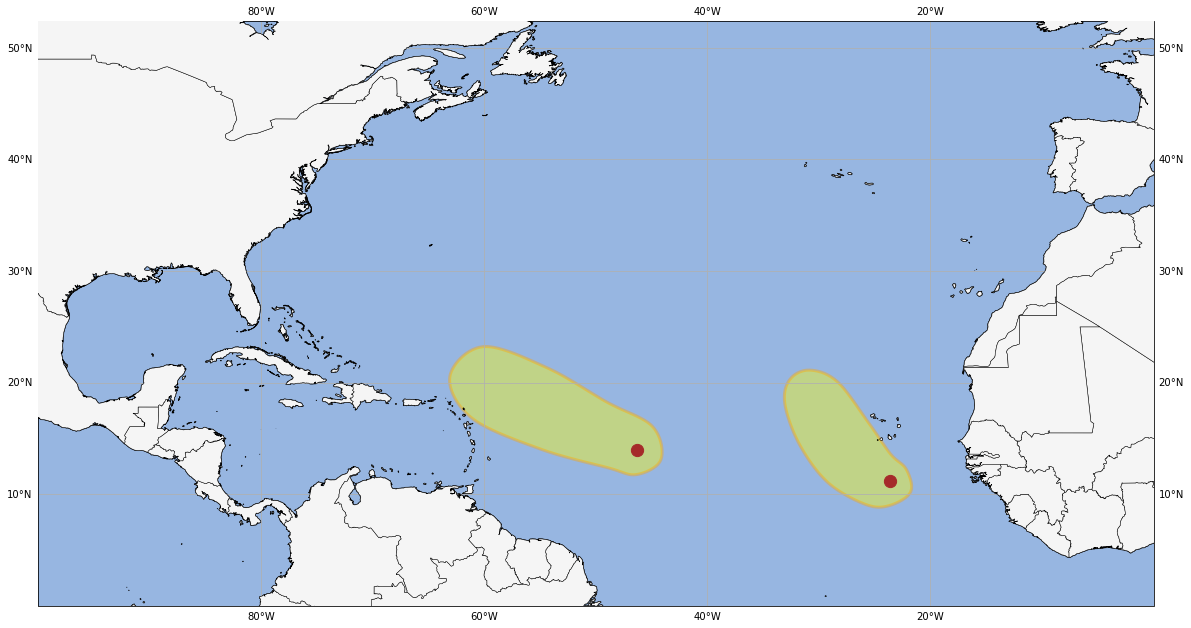

In [8]:
gtwo_areas_gdf  = nch_dl.gtwo_areas_gdf .loc[nch_dl .gtwo_areas_gdf  ['BASIN']     == 'Atlantic']
gtwo_lines_gdf  = nch_dl.gtwo_lines_gdf .loc[nch_dl .gtwo_lines_gdf  ['BASIN']     == 'Atlantic']
gtwo_points_gdf = nch_dl.gtwo_points_gdf.loc[nch_dl .gtwo_points_gdf ['BASIN']     == 'Atlantic']

ax_w = map_template.wide_map()

ax_w.add_geometries(gtwo_areas_gdf['geometry'], crs=map_template.data_crs, facecolor='yellow',
                    edgecolor='orange', linewidth=3, alpha = 0.4)
ax_w.add_geometries(gtwo_lines_gdf['geometry'], crs=map_template.data_crs, facecolor='none',
                   edgecolor='orange', linewidth=2)
ax_w.scatter(gtwo_points_gdf['geometry'].x, gtwo_points_gdf['geometry'].y,
           transform=map_template.data_crs, zorder=100, color = 'brown', s=150)

# ax.add_geometries(gdf_names[file_names[0]][1]['geometry'], crs=data_crs, facecolor='white',
#                  edgecolor='black', linewidth=1, alpha=0.7)
# ax.add_geometries(gdf_names[file_names[0]][0]['geometry'], crs=data_crs, facecolor='none',
#                  edgecolor='black', linewidth=2)
# sc = ax.scatter(gdf_names[file_names[0]][2]['LON'], gdf_names[file_names[0]][2]['LAT'],transform=data_crs,
#                 zorder=10)



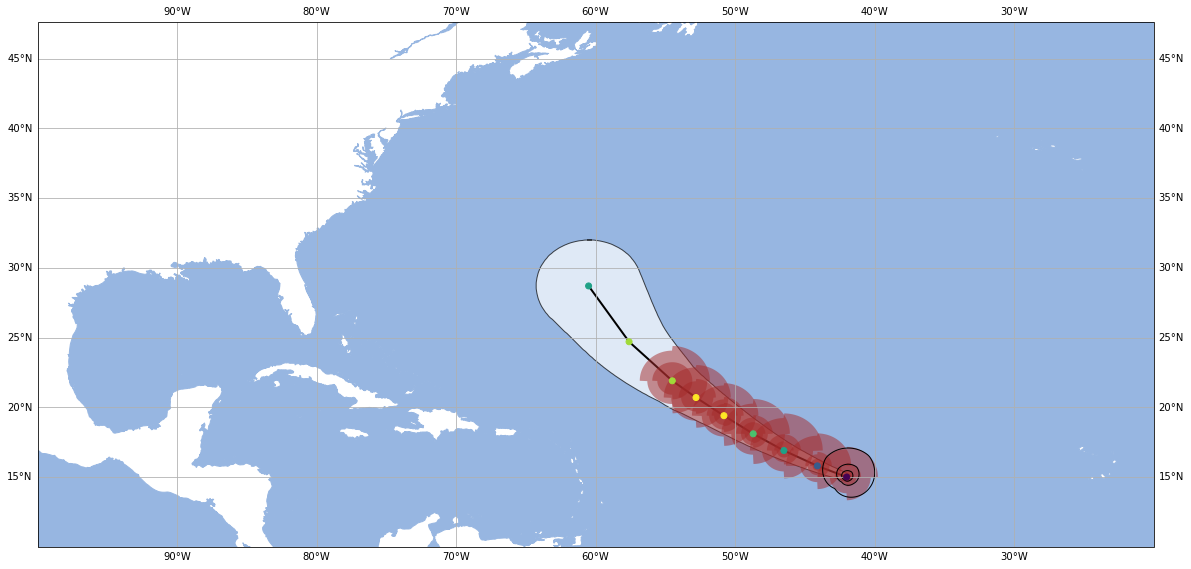

In [22]:
fig = plt.figure(figsize=(20, 20))
ax  = plt.subplot(1, 1, 1, projection = map_crs)

ax.set_extent([-100, -20, 10, 40])
#ax.set_extent([-72, -68, 17.5, 20])
ax.add_feature(cfeat.OCEAN.with_scale('10m'))

grid_lines = ax.gridlines(draw_labels=True)
grid_lines.xformatter = LONGITUDE_FORMATTER
grid_lines.yformatter = LATITUDE_FORMATTER

# ax.add_geometries(ocean_gdf['geometry'], crs=data_crs, facecolor='lightblue',
#                  edgecolor='none')
# ax.add_geometries(land_gdf['geometry'], crs=data_crs, facecolor='lightgray',
#                  edgecolor='none', alpha = 0.5)
# ax.add_geometries(states_provinces_gdf['geometry'], crs=data_crs, facecolor='none',
#                  edgecolor='black', linewidth=0.5, alpha=0.7)
# ax.add_geometries(coastline_gdf['geometry'], crs=data_crs, facecolor='none',
#                  edgecolor='black', linewidth=1, alpha=0.7)

ax.add_geometries(gdf_names[file_names[0]][1]['geometry'], crs=data_crs, facecolor='white',
                 edgecolor='black', linewidth=1, alpha=0.7)
ax.add_geometries(gdf_names[file_names[0]][0]['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='black', linewidth=2)
sc = ax.scatter(gdf_names[file_names[0]][2]['LON'], gdf_names[file_names[0]][2]['LAT'],transform=data_crs,
                zorder=10, c=gdf_names[file_names[0]][2]['MAXWIND'])
ax.add_geometries(gdf_names[file_names[1]][0]['geometry'], crs=data_crs, facecolor='brown',
                 edgecolor='none', linewidth=0.1, alpha=0.5)
ax.add_geometries(gdf_names[file_names[1]][1]['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='black', linewidth=1)

# ww_colors = {'TWA': 'yellow',
#              'HWA': 'pink',
#              'TWR': 'blue',
#              'HWR': 'tab:red'}

# for ww_type in ww_colors.keys():
#     ww_subset = ww_gdf[ww_gdf['TCWW']==ww_type]
#     ax.add_geometries(ww_subset['geometry'], facecolor='none',
#                      edgecolor=ww_colors[ww_type], crs=data_crs,
#                      linewidth=5)
#plt.colorbar(sc)

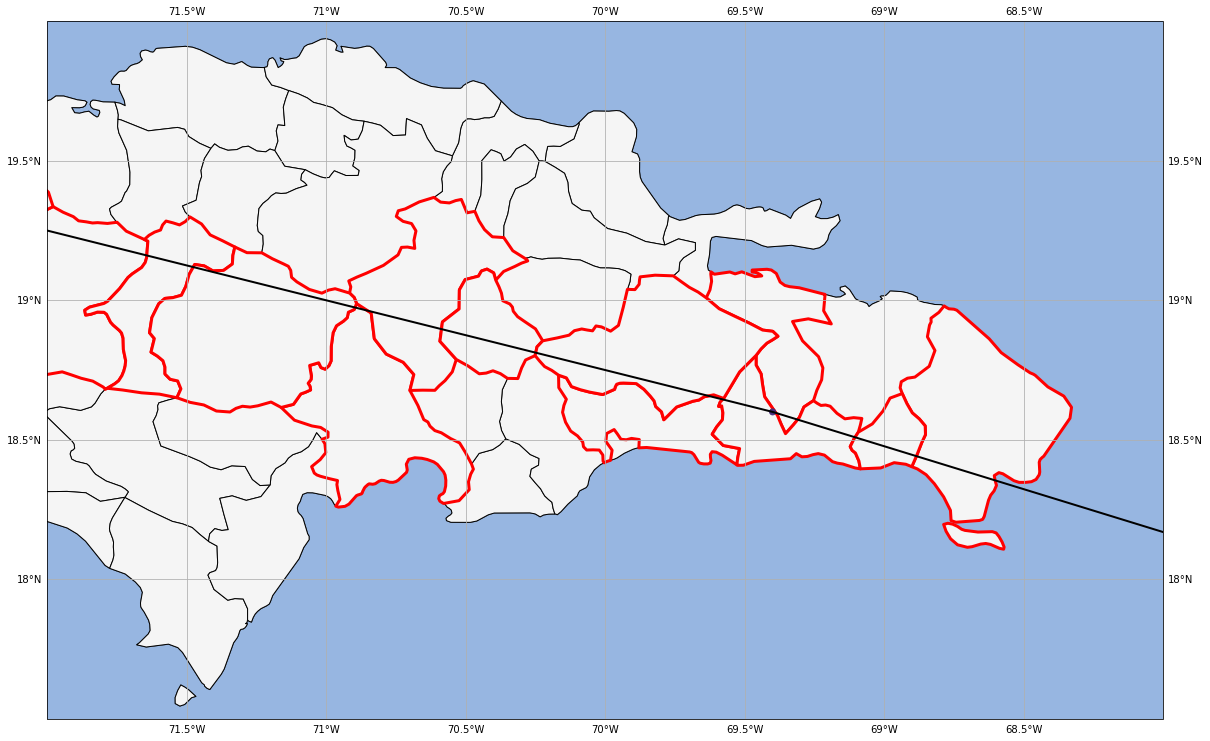

In [14]:
fig = plt.figure(figsize=(20, 20))
ax  = plt.subplot(1, 1, 1, projection = map_crs)

ax.set_extent([-100, -50, 10, 40])
ax.set_extent([-72, -68, 17.5, 20])
ax.add_feature(cfeat.OCEAN.with_scale('10m'))

grid_lines = ax.gridlines(draw_labels=True)
grid_lines.xformatter = LONGITUDE_FORMATTER
grid_lines.yformatter = LATITUDE_FORMATTER


ax.add_geometries(land_gdf['geometry'], crs=data_crs, facecolor='lightgray',
                 edgecolor='none', alpha = 0.5)

ax.add_geometries(coastline_gdf['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='black', linewidth=1, alpha=0.7)


ax.add_geometries(track_line_gdf['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='black', linewidth=2, zorder = 100)
sc = ax.scatter(points_gdf['LON'], points_gdf['LAT'],transform=data_crs,
                zorder=100, c=points_gdf['MAXWIND'])
track = sgeom.LineString(zip(points_gdf['LON'], points_gdf['LAT']))

def colorize_state(geometry):
        #facecolor = (0.9375, 0.9375, 0.859375)
        edgecolor  =  'black'
        linewidth  =     1
        if geometry.intersects(track):
            #facecolor = 'red'
            edgecolor = 'red'
            linewidth =   3
        return {'facecolor': 'whitesmoke', 'edgecolor': edgecolor, 'linewidth': linewidth}
ax.add_geometries(states_provinces_gdf['geometry'], crs=data_crs, styler=colorize_state)
# ax.add_geometries(
#         shpreader.Reader(states_shp).geometries(),
#         ccrs.PlateCarree(),
#         styler=colorize_state)

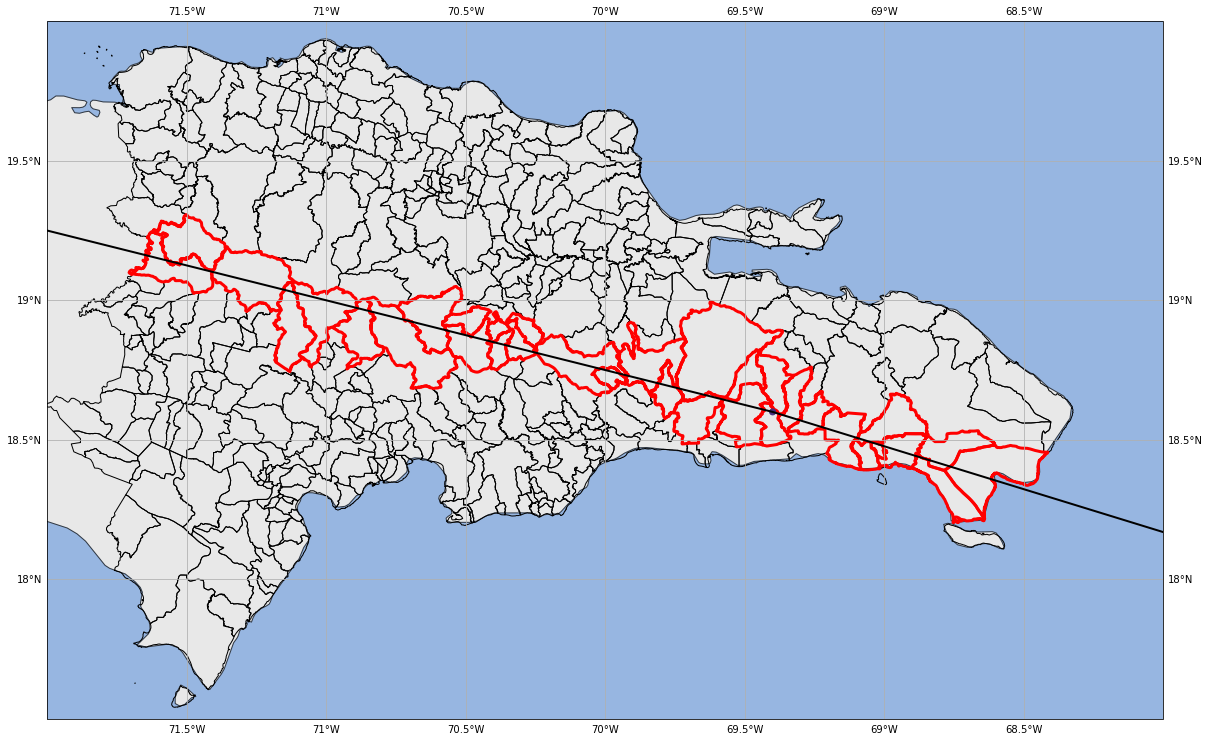

In [15]:
fig = plt.figure(figsize=(20, 20))
ax  = plt.subplot(1, 1, 1, projection = map_crs)

ax.set_extent([-100, -50, 10, 40])
ax.set_extent([-72, -68, 17.5, 20])
ax.add_feature(cfeat.OCEAN.with_scale('10m'))

grid_lines = ax.gridlines(draw_labels=True)
grid_lines.xformatter = LONGITUDE_FORMATTER
grid_lines.yformatter = LATITUDE_FORMATTER


ax.add_geometries(land_gdf['geometry'], crs=data_crs, facecolor='lightgray',
                 edgecolor='none', alpha = 0.5)

ax.add_geometries(coastline_gdf['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='black', linewidth=1, alpha=0.7)


ax.add_geometries(track_line_gdf['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='black', linewidth=2, zorder = 100)
sc = ax.scatter(points_gdf['LON'], points_gdf['LAT'],transform=data_crs,
                zorder=100, c=points_gdf['MAXWIND'])
track = sgeom.LineString(zip(points_gdf['LON'], points_gdf['LAT']))

def colorize_state(geometry):
        #facecolor = (0.9375, 0.9375, 0.859375)
        edgecolor  =  'black'
        linewidth  =     1
        if geometry.intersects(track):
            #facecolor = 'red'
            edgecolor = 'red'
            linewidth =   3
        return {'edgecolor': edgecolor, 'linewidth': linewidth}

ax.add_geometries(división_prov_muni_y_dist_muni['geometry'], crs=data_crs, styler=colorize_state, facecolor='none')

# ax.add_geometries(
#         shpreader.Reader(states_shp).geometries(),
#         ccrs.PlateCarree(),
#         styler=colorize_state)

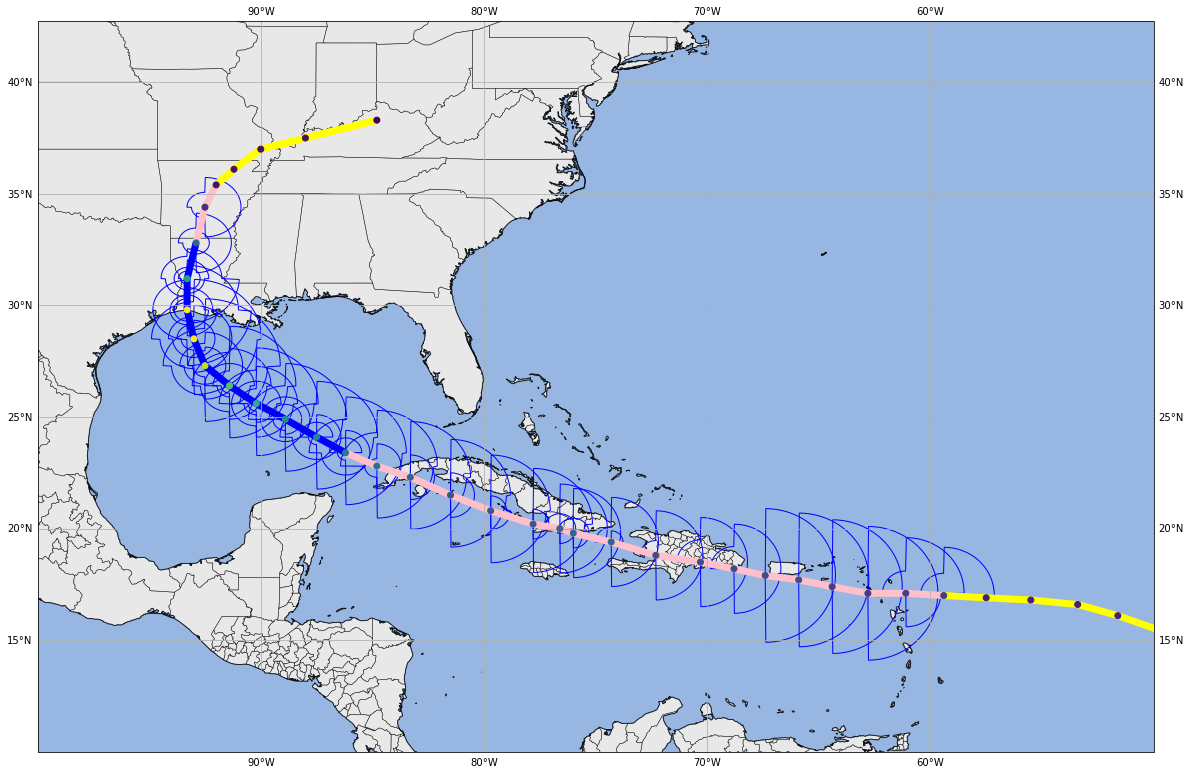

In [16]:
fig = plt.figure(figsize=(20, 20))
ax  = plt.subplot(1, 1, 1, projection = map_crs)

ax.set_extent([-100, -50, 10, 40])
ax.add_feature(cfeat.OCEAN.with_scale('10m'))

grid_lines = ax.gridlines(draw_labels=True)
grid_lines.xformatter = LONGITUDE_FORMATTER
grid_lines.yformatter = LATITUDE_FORMATTER

# ax.add_geometries(ocean_gdf['geometry'], crs=data_crs, facecolor='lightblue',
#                  edgecolor='none')
ax.add_geometries(land_gdf['geometry'], crs=data_crs, facecolor='lightgray',
                 edgecolor='none', alpha = 0.5)
ax.add_geometries(states_provinces_gdf['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='black', linewidth=0.5, alpha=0.7)
ax.add_geometries(coastline_gdf['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='black', linewidth=1, alpha=0.7)


sc_2 = ax.scatter(best_track_points_gdf['LON'], best_track_points_gdf['LAT'],
                  transform=data_crs, zorder=10, c=best_track_points_gdf['INTENSITY'])
# ax.add_geometries(best_track_line_gdf['geometry'], crs=data_crs, facecolor='none',
#                   edgecolor='black', linewidth=2)
ax.add_geometries(best_track_radii_gdf['geometry'], crs=data_crs, facecolor='none',
                  edgecolor='blue')
# ax.add_geometries(best_track_swath_gdf['geometry'], crs=data_crs, facecolor='none',
#                   edgecolor='white')

btl_colors ={'TD': 'yellow',
             'TS': 'pink',
             'HU': 'blue',
             'MH': 'tab:red'}

for btl_type in btl_colors.keys():
    btl_subset = best_track_line_gdf[best_track_line_gdf['STORMTYPE']== btl_type]
    ax.add_geometries(btl_subset['geometry'], facecolor='none',
                     edgecolor=btl_colors[btl_type], crs=data_crs,
                     linewidth=7, alpha = 1)

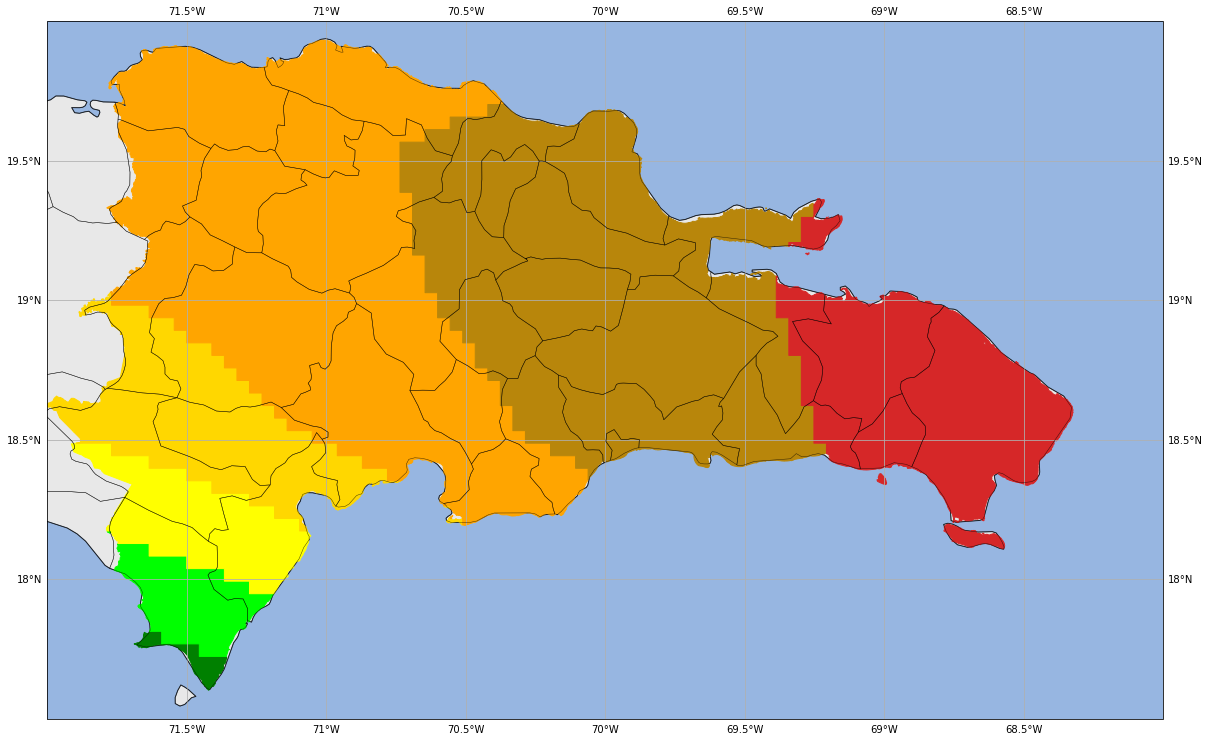

In [145]:
fig = plt.figure(figsize=(20, 20))
ax  = plt.subplot(1, 1, 1, projection = map_crs)

wsp_34_gdf = geopandas.read_file('laura_shape_files/2020082212_wsp_120hr/2020082212_wsp34knt120hr_5km.shp')

ax.set_extent([-100, -50, 10, 40])
ax.set_extent([-72, -68, 17.5, 20])

ax.add_feature(cfeat.OCEAN.with_scale('10m'))

grid_lines = ax.gridlines(draw_labels=True)
grid_lines.xformatter = LONGITUDE_FORMATTER
grid_lines.yformatter = LATITUDE_FORMATTER

# ax.add_geometries(ocean_gdf['geometry'], crs=data_crs, facecolor='lightblue',
#                  edgecolor='none')
ax.add_geometries(land_gdf['geometry'], crs=data_crs, facecolor='lightgray',
                 edgecolor='none', alpha = 0.5, zorder = -1)
ax.add_geometries(states_provinces_gdf['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='black', linewidth=0.5, alpha=0.7, zorder = 10)
ax.add_geometries(coastline_gdf['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='black', linewidth=1, alpha=0.7)


# ax.add_geometries(wsp_34_gdf['geometry'], crs=data_crs, facecolor='none',
#                  edgecolor='black', alpha=0.8)
    

wsp_colors = {'<5%'   : 'none',   '5-10%' : 'darkgreen','10-20%': 'green', '20-30%' : 'lime',
              '30-40%': 'yellow', '40-50%': 'gold',     '50-60%': 'orange','60-70%' : 'darkgoldenrod',
              '70-80%': 'tab:red','80-90%': 'brown',    '>90%'  : 'purple'}

# for wsp_type in wsp_colors.keys():
#     wsp_subset = wsp_34_gdf[wsp_34_gdf['PERCENTAGE']== wsp_type]
#     ax.add_geometries(wsp_subset['geometry'], facecolor=wsp_colors[wsp_type],
#                      edgecolor=wsp_colors[wsp_type], crs=data_crs,
#                      linewidth=1, alpha = 1)


wsp_34_smoothed_gdf = wsp_34_gdf['geometry'].simplify(0, preserve_topology=True)
wsp_34_gdf['geometry'] = wsp_34_smoothed_gdf

wsp_34_gdf = geopandas.clip(wsp_34_gdf, PROVINCIAS_gdf.to_crs(4035))

# ax.add_geometries(wsp_34_smoothed_gdf, facecolor='none',
#                      edgecolor='black', crs=data_crs,
#                      linewidth=1)

for wsp_type in wsp_colors.keys():
    wsp_subset = wsp_34_gdf[wsp_34_gdf['PERCENTAGE']== wsp_type]
    _ = ax.add_geometries(wsp_subset['geometry'], facecolor=wsp_colors[wsp_type],
                     edgecolor=wsp_colors[wsp_type], crs=data_crs,
                     linewidth=1, alpha = 1)


0           Annotation(115, 37, '0.10000000149011612')
1         Annotation(115, 37.5, '0.10000000149011612')
2           Annotation(115, 38, '0.10000000149011612')
3         Annotation(115, 38.5, '0.10000000149011612')
4           Annotation(115, 39, '0.10000000149011612')
                             ...                      
5008     Annotation(-63.5, 18.5, '1.7999999523162842')
5009       Annotation(-63.5, 19, '0.6000000238418579')
5010     Annotation(-63.5, 19.5, '0.4000000059604645')
5011      Annotation(-63.5, 20, '0.20000000298023224')
5012    Annotation(-63.5, 20.5, '0.10000000149011612')
Length: 5013, dtype: object

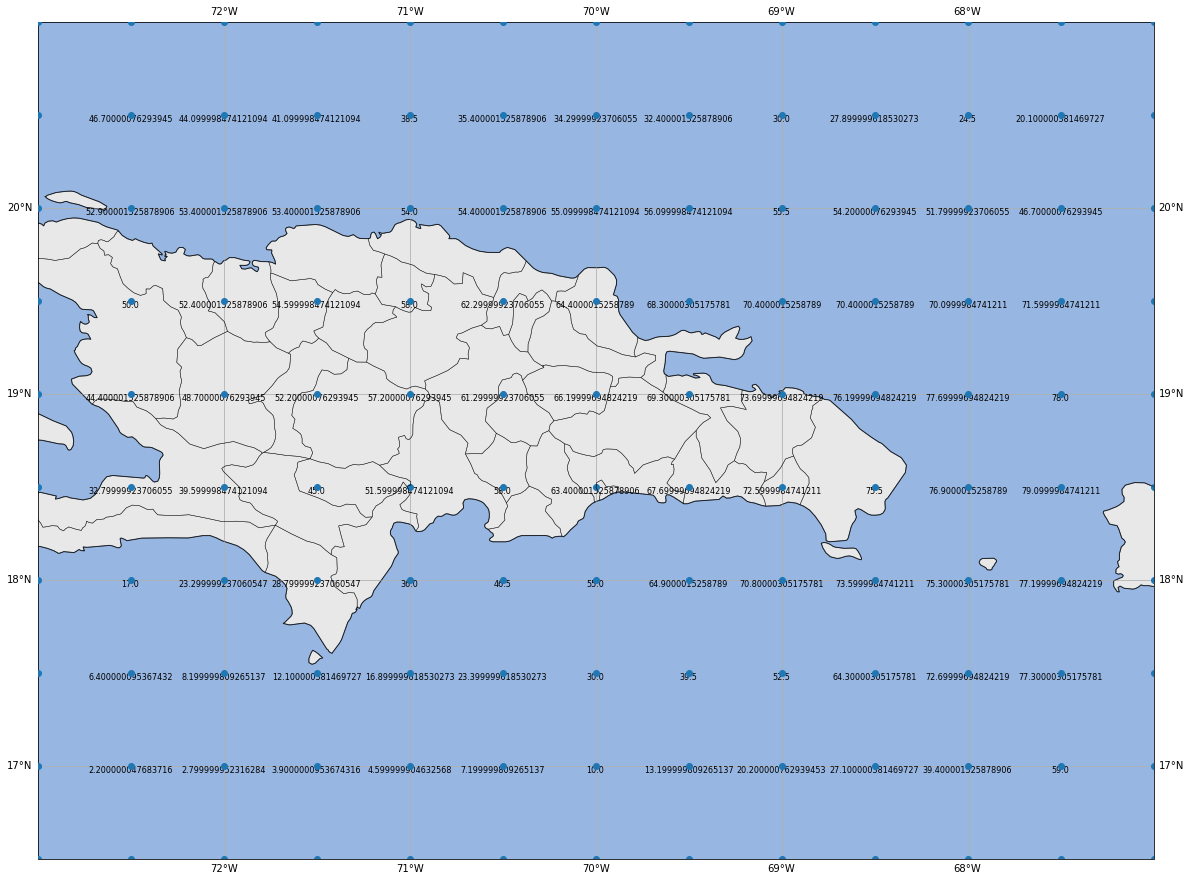

In [20]:
fig = plt.figure(figsize=(20, 20))
ax  = plt.subplot(1, 1, 1, projection = map_crs)

ax.set_extent([-100, -50, 10, 40])
ax.set_extent([-73, -67, 16.5, 21])
ax.add_feature(cfeat.OCEAN.with_scale('10m'))

grid_lines = ax.gridlines(draw_labels=True)
grid_lines.xformatter = LONGITUDE_FORMATTER
grid_lines.yformatter = LATITUDE_FORMATTER

# ax.add_geometries(ocean_gdf['geometry'], crs=data_crs, facecolor='lightblue',
#                  edgecolor='none')
ax.add_geometries(land_gdf['geometry'], crs=data_crs, facecolor='lightgray',
                 edgecolor='none', alpha = 0.5, zorder = -1)
ax.add_geometries(states_provinces_gdf['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='black', linewidth=0.5, alpha=0.7, zorder = 10)
ax.add_geometries(coastline_gdf['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='black', linewidth=1, alpha=0.7)

wsp_34_points_gdf = geopandas.read_file('laura_shape_files/2020082212_wsp_120hr/2020082212_wsp34knt120hr_halfDeg.shp')
wsp_34_points_gdf["PWIND120"] = pandas.to_numeric(wsp_34_points_gdf["PWIND120"], downcast="float")
wsp_34_points_gdf = wsp_34_points_gdf[wsp_34_points_gdf['PWIND120'] > 0]

ax.scatter(wsp_34_points_gdf['geometry'].x, wsp_34_points_gdf['geometry'].y,
                  transform=data_crs,  zorder=10)

wsp_34_points_gdf.apply(lambda x: ax.annotate(text=x.PWIND120, xy=(x.geometry.x, x.geometry.y), 
                                                fontsize = 8, ha='center', weight = 'normal', 
                                                va = 'top'), axis=1)
# ax.add_geometries(wsp_34_gdf['geometry'], crs=data_crs, facecolor='none',
#                  edgecolor='black', alpha=0.8)

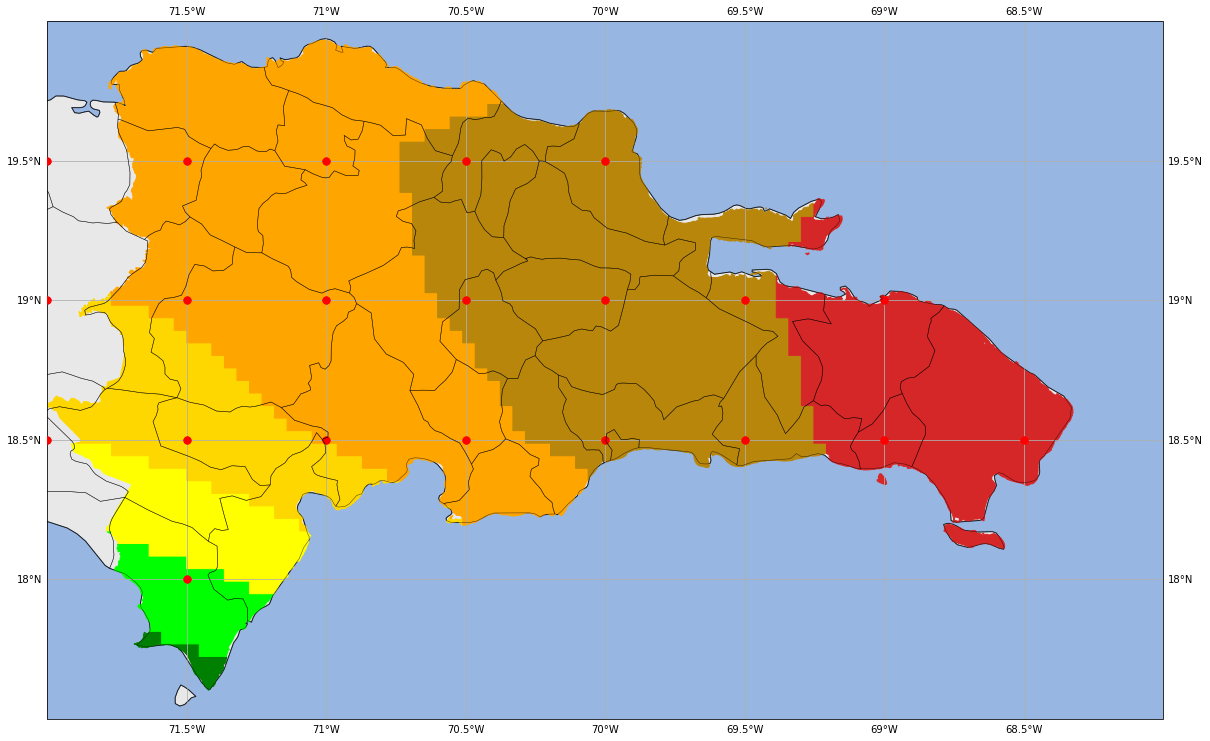

In [151]:
from shapely.ops import nearest_points

wsp_34_clipped = geopandas.clip(wsp_34_points_gdf, hispaniola_gdf.to_crs(4035))

ax.scatter(wsp_34_clipped['geometry'].x, wsp_34_clipped['geometry'].y,
                  transform=data_crs,  color = 'red', s= 50, zorder=10)




fig

In [160]:
PROVINCIAS_gdf.apply(lambda x: nearest_points(Point(x['Longitud'],
                                                    x['Latitud']), list(wsp_34_clipped['geometry'])), 
                     axis=1)

AttributeError: 'list' object has no attribute '_geom'

In [164]:
type(list(wsp_34_clipped['geometry'])[0])

shapely.geometry.point.Point

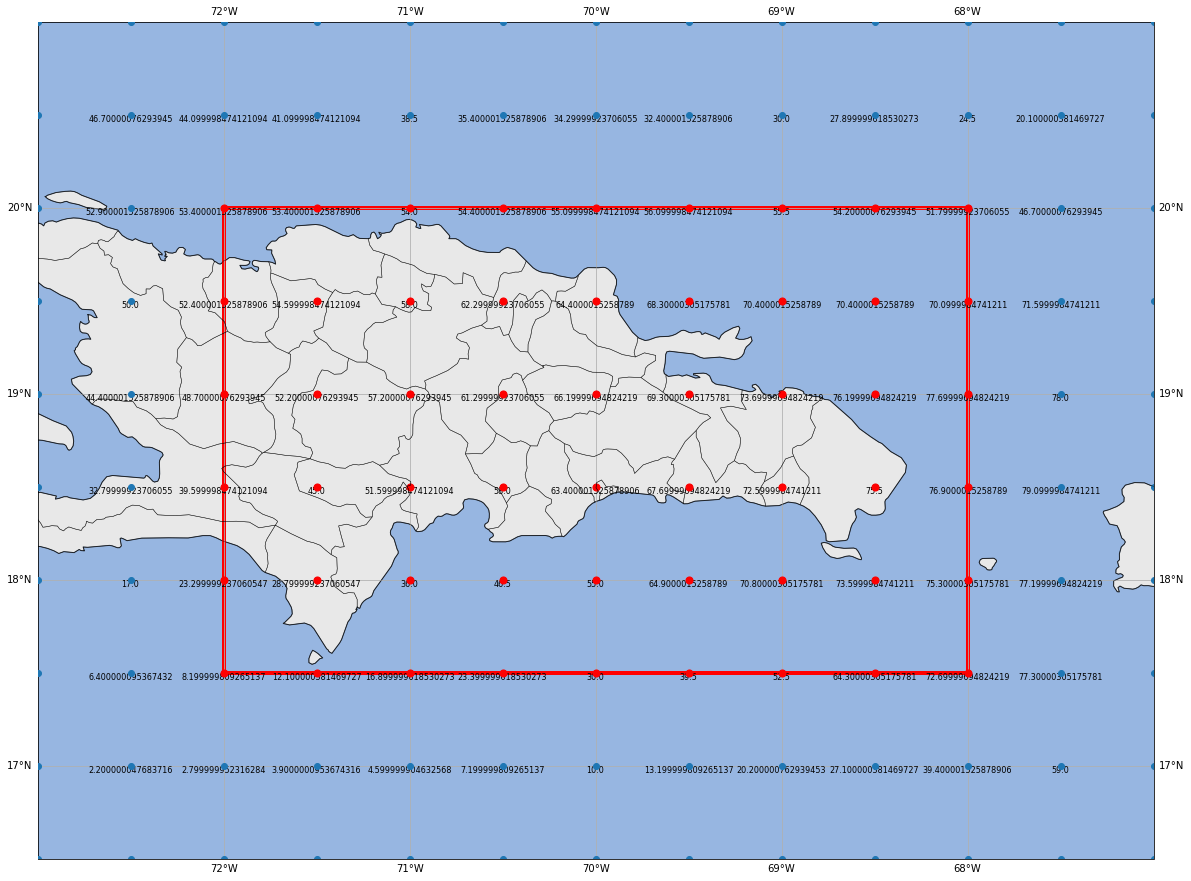

In [21]:
polygon = Polygon([(-72, 17.5), (-72, 20), (-68, 20), (-68, 17.5), (-72, 17.5)])
poly_gdf = geopandas.GeoDataFrame([1], geometry=[polygon], crs=states_provinces_gdf.crs)

wsp_34_clipped = geopandas.clip(wsp_34_points_gdf, polygon)
ax.add_geometries(poly_gdf['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='red', linewidth=4)
ax.scatter(wsp_34_clipped['geometry'].x, wsp_34_clipped['geometry'].y,
                  transform=data_crs,  color = 'red', s= 50, zorder=10)
fig

In [22]:
x = np.array(wsp_34_clipped['geometry'].x)
y = np.array(wsp_34_clipped['geometry'].y)
points = list(zip(x, y))
values = wsp_34_clipped['PWIND120']


(-72.24489795918366,
 -67.75510204081634,
 17.346938775510203,
 20.153061224489797)

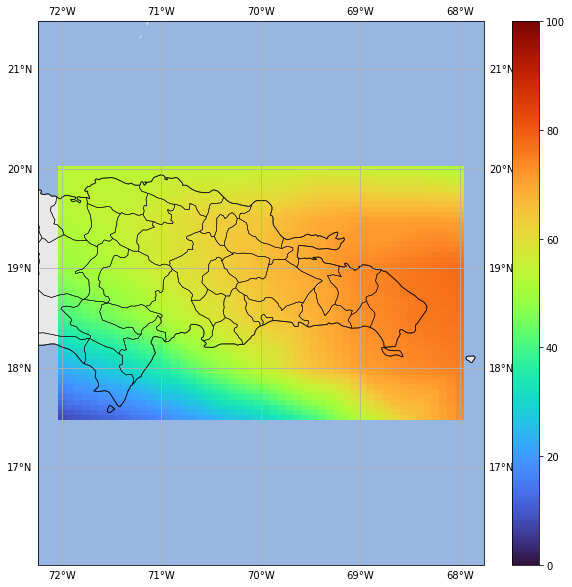

In [23]:
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax  = plt.subplot(1, 1, 1, projection = map_crs)


#ax.set_extent([-73, -67, 16.5, 21])
ax.set_extent([-72, -68, 17.5, 20])
ax.add_feature(cfeat.OCEAN.with_scale('10m'))

grid_lines = ax.gridlines(draw_labels=True)
grid_lines.xformatter = LONGITUDE_FORMATTER
grid_lines.yformatter = LATITUDE_FORMATTER


ax.add_geometries(land_gdf['geometry'], crs=data_crs, facecolor='lightgray',
                 edgecolor='none', alpha = 0.5, zorder = -1)
ax.add_geometries(states_provinces_gdf['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='black', linewidth=0.5, zorder = 10)
ax.add_geometries(coastline_gdf['geometry'], crs=data_crs, facecolor='none',
                 edgecolor='black', linewidth=1, alpha=0.7)

wsp_34_points_gdf = geopandas.read_file('laura_shape_files/2020082212_wsp_120hr/2020082212_wsp34knt120hr_halfDeg.shp')
wsp_34_points_gdf["PWIND120"] = pandas.to_numeric(wsp_34_points_gdf["PWIND120"], downcast="float")
wsp_34_points_gdf = wsp_34_points_gdf[wsp_34_points_gdf['PWIND120'] > 0]

# ax.scatter(wsp_34_points_gdf['geometry'].x, wsp_34_points_gdf['geometry'].y,
#                   transform=data_crs,  zorder=10)

# wsp_34_points_gdf.apply(lambda x: ax.annotate(text=round(x.PWIND120), xy=(x.geometry.x, x.geometry.y), 
#                                                 fontsize = 8, ha='center', weight = 'normal', 
#                                                 va = 'top'), axis=1)
polygon = Polygon([(-72, 17.5), (-72, 20), (-68, 20), (-68, 17.5), (-72, 17.5)])
poly_gdf = geopandas.GeoDataFrame([1], geometry=[polygon], crs=states_provinces_gdf.crs)

wsp_34_clipped = geopandas.clip(wsp_34_points_gdf, polygon)
# ax.add_geometries(poly_gdf['geometry'], crs=data_crs, facecolor='none',
#                  edgecolor='red', linewidth=4)
# ax.scatter(wsp_34_clipped['geometry'].x, wsp_34_clipped['geometry'].y,
#                   transform=data_crs,  color = 'red', s= 50, zorder=10)


x = np.array(wsp_34_clipped['geometry'].x)
y = np.array(wsp_34_clipped['geometry'].y)
points = list(zip(x, y))
values = wsp_34_clipped['PWIND120']


X = np.linspace(min(x), max(x))
Y = np.linspace(min(y), max(y))
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation

interp = LinearNDInterpolator(points, values)
Z = interp(X, Y)

ax.set_extent([-90, -60, 15, 25], crs=data_crs)
pc = ax.pcolormesh(X, Y, Z, shading='auto', cmap = 'turbo', vmin = 0, vmax = 100, transform=data_crs)
# ax.plot(x, y, "ok")
#ax.legend()
plt.colorbar(pc)

ax.axis("equal")


In [24]:
Y

array([[17.5       , 17.5       , 17.5       , ..., 17.5       ,
        17.5       , 17.5       ],
       [17.55102041, 17.55102041, 17.55102041, ..., 17.55102041,
        17.55102041, 17.55102041],
       [17.60204082, 17.60204082, 17.60204082, ..., 17.60204082,
        17.60204082, 17.60204082],
       ...,
       [19.89795918, 19.89795918, 19.89795918, ..., 19.89795918,
        19.89795918, 19.89795918],
       [19.94897959, 19.94897959, 19.94897959, ..., 19.94897959,
        19.94897959, 19.94897959],
       [20.        , 20.        , 20.        , ..., 20.        ,
        20.        , 20.        ]])

In [25]:
# cmap = cmaps['Qualitative'] = ['none', 'darkgreen', 'green', 'Accent',
#                         'lime', 'yellow', 'gold', 'orange',
#                         'darkgoldenrod', 'tab:red', 'brown', 'purple']


cmap

NameError: name 'cmaps' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 12)
viridis

In [ ]:
viridis(0.56)